# BQSKit Compilation with Error Mitigation

In this tutorial we will describe how to use error mitigation capabilities from [Mitiq](https://mitiq.readthedocs.io/en/stable/), together with the compilation capabilities of [BQSKit](https://bqskit.lbl.gov/).

Before getting started, run the following install commands to ensure you have the required python packages.
- `pip install mitiq`
- `pip install bqskit==0.3.0` (here we use an older version of `bqskit` in order to satisfy version requirements between the two packages)

The main steps taken in this tutorial are:
1. Generate a random circuit
2. Compile it with `bqskit`
3. Use error mitigation on the compiled circuit
4. Compare the results obtained with and without error mitigation

---

To begin we import many of the required functions.

In [1]:
import mitiq
import bqskit

import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
import numpy as np

## Random circuit generation

To begin, we use `cirq`'s [`random_circuit`](https://quantumai.google/reference/python/cirq/testing/random_circuit) function to generare a random circuit with specified qubit number, depth and density (which refers to the probability of an operation occuring at a given moment).
Here we also use a random seed for reproducibility.

In [2]:
num_qubits = 3
depth = 10
density = 1
RANDOM_SEED = 479

random_circuit = cirq.testing.random_circuit(num_qubits, depth, density, random_state=RANDOM_SEED)

In [3]:
print(random_circuit)

                                          ┌──┐
0: ───X───Z───Y───X───────────────iSwap─────@────H───Y───
                  │               │         │
1: ───S───X───────@───Y───iSwap───┼────────S┼────X───X───
          │               │       │         │
2: ───────@───S───Y───Y───iSwap───iSwap─────@────────────
                                          └──┘


We now write the circuit out to QASM for consumption by `bqskit`.
Here we must remove the `// Generated from Cirq v1.0.0` comment at the beginning of the file to ensure `bqskit` can properly consume the operations described therein.

In [4]:
qasm_code = cirq.qasm(random_circuit)
with open('tmp.qasm', 'w') as f:
    f.write(qasm_code[31:]) # remove google prefix

## Compilation

The temporary file can then be read in by `bqskit`, and compiled.
By default `bqskit` attempts to reduce the circuit depth as its primary optimization, and compiles into the following gateset: $\{\mathsf{U3}, \mathsf{CNOT}, \sqrt{X}, R_Z\}$.

In [5]:
bqs_circuit = bqskit.ir.Circuit.from_file('tmp.qasm')
task = bqskit.compiler.CompilationTask.optimize(bqs_circuit)

with bqskit.compiler.Compiler() as compiler:
    compiled_bqs_circuit = compiler.compile(task)

Since `bqskit` uses a custom intermediate representation, we need to now convert this circuit to a form we can use for futher processing, and error mitigation. This can be done easily by writing the circuit back to QASM, which `cirq` can then read in.

In [6]:
compiled_bqs_circuit.save('out.qasm')

with open('out.qasm') as f:
    qasm_out = f.read()
    
compiled_circuit = circuit_from_qasm(qasm_out)

## Error Mitigation

Now that we have a compiled circuit, we are ready to use `mitiq`'s error mitigation capabilities.
In this tutorial we will use one of the simplest, and easiest to use methods: [Zero Noise Extrapolation](https://mitiq.readthedocs.io/en/stable/guide/zne-1-intro.html) (ZNE), but there are multiple other techniques described in our [user guide](https://mitiq.readthedocs.io/en/stable/guide/guide.html).

To use this method, we need to define a function which takes as input a circuit, and returns some sort of expectation value, or probability. Here we will define a function `execute` which adds a tunable noise parameter, which controls the strength of our assumed two-qubit depolarizing noise model. Then a density matrix simulation is run, and we measure the probability of observing the system in the ground state(s).

In [7]:
def execute(circuit, noise_level=0.05):
    noisy_circuit = cirq.Circuit()
    for op in circuit.all_operations():
        noisy_circuit.append(op)
        if len(op.qubits) == 2:
            noisy_circuit.append(cirq.depolarize(p=noise_level, n_qubits=2)(*op.qubits))
    
    rho = cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real

Since we'd like to see how compilation effects error mitigation, we run the `execute` function on both the compiled, and random circuits, both with and without noise.

In [8]:
uncompiled_ideal_value = execute(random_circuit, noise_level=0.0)
uncompiled_noisy_value = execute(random_circuit)

compiled_ideal_value = execute(compiled_circuit, noise_level=0.0)
compiled_noisy_value = execute(compiled_circuit)

We can now use ZNE --- on both the random, and compiled circuit --- to obtain the mitigated expectation values for these circuits.

In [9]:
from mitiq import zne

uncompiled_mitigated_result = zne.execute_with_zne(random_circuit, execute)
compiled_mitigated_result = zne.execute_with_zne(compiled_circuit, execute)

## Comparison

These data are then summarized in the following output.

In [10]:
header = "{:<11} {:<15} {:<10}"
entry = "{:<11}  {:<15.2f} {:<10.2f}"
int_entry = "{:<11}  {:<15} {:<10}"
print(header.format("", "uncompiled", "compiled"))
print(entry.format("ideal", uncompiled_ideal_value, compiled_ideal_value))
print(entry.format("noisy", uncompiled_noisy_value, compiled_noisy_value))
print(entry.format("mitigated", uncompiled_mitigated_result, compiled_mitigated_result))
print(entry.format(
    "error",
    abs(uncompiled_ideal_value - uncompiled_mitigated_result),
    abs(compiled_ideal_value - compiled_mitigated_result),
))
print(int_entry.format(
    "depth",
    len(random_circuit),
    len(compiled_circuit),
))

            uncompiled      compiled  
ideal        0.50            0.50      
noisy        0.43            0.42      
mitigated    0.33            0.53      
error        0.17            0.03      
depth        10              13        


Hence for this particular random circuit we see that using both compilation _and_ error mitigation combine for the most accurate result.
Note that despite using BQSKit to compile the circuit, the depth has actually increased. 
This can occsionally happen when the random circuit contains gates that are harder to compile into BQSKit's default gateset.

We can now wrap this code into a loop to get a better understanding of how errors change for the following four combinations of compilation and mitigation:

| compiled | mitigated |
| -------- | --------- |
| ❌       | ❌         |
| ❌       | ✅         |
| ✅       | ❌         |
| ✅       | ✅         |

In [88]:
from tqdm import tqdm

num_circuits = 200
num_qubits = 4
depth = 40

ideal_uncompiled, ideal_compiled = [], []
mitigated_uncompiled, mitigated_compiled = [], []
unmitigated_uncompiled, unmitigated_compiled = [], []
depths = []

for i in tqdm(range(num_circuits)):
    random_circuit = cirq.testing.random_circuit(num_qubits, depth, 1)
    qasm_code = cirq.qasm(random_circuit)
    with open(f'tmp{i}.qasm', 'w') as f:
        f.write(qasm_code[31:])
        
    bqs_circuit = bqskit.ir.Circuit.from_file(f'tmp{i}.qasm')
    task = bqskit.compiler.CompilationTask.optimize(bqs_circuit)
    with bqskit.compiler.Compiler() as compiler:
        optimized_circuit = compiler.compile(task)

    optimized_circuit.save(f'out{i}.qasm')
    with open(f'out{i}.qasm') as f:
        qasm_out = f.read()
    compiled_circuit = circuit_from_qasm(qasm_out)
    
    depths.append((len(random_circuit), len(compiled_circuit)))
    
    ideal_uncompiled.append(execute(random_circuit, noise_level=0.0))
    ideal_compiled.append(execute(compiled_circuit, noise_level=0.0))
    
    unmitigated_uncompiled.append(execute(random_circuit))
    unmitigated_compiled.append(execute(compiled_circuit))

    mitigated_uncompiled.append(zne.execute_with_zne(random_circuit, execute))
    mitigated_compiled.append(zne.execute_with_zne(compiled_circuit, execute))

 46%|███████████████████████████████████████████▏                                                  | 92/200 [1:43:19<1:35:47, 53.22s/it]ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-89138' coro=<Cluster._sync_cluster_info() done, defined at /Users/nate/opt/anaconda3/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fea56200fa0>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/nate/opt/anaconda3/lib/python3.9/site-packages/tornado/ioloop.py:688]>
 47%|████████████████████████████████████████████▏                                                 | 94/200 [1:46:35<2:02:15, 69.20s/it]ERROR - Task was destroyed but it is pending!
task: <Task pending name='Task-89666' coro=<Cluster._sync_cluster_info() done, defined at /Users/nate/opt/anaconda3/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fea75739

As a sanity check we ensure that the ideal values for the random circuit, and its compiled counterpart are equivalent up to $10^{-7}$.

In [99]:
np.allclose(ideal_uncompiled, ideal_compiled, atol=1e-7)

True

To see how compilation, and mitigation effect the overall accuracy of the measured observables, we calculate the errors.

In [91]:
uncompiled_error, compiled_error = [], []
uncompiled_unmitigated_error, compiled_unmitigated_error = [], []

for ideal, uncompiled, compiled, noisy_uncompiled, noisy_compiled in zip(ideal_uncompiled, mitigated_uncompiled, mitigated_compiled, unmitigated_uncompiled, unmitigated_compiled):
    uncompiled_error.append(abs(ideal - uncompiled))
    compiled_error.append(abs(ideal - compiled))
    uncompiled_unmitigated_error.append(abs(ideal - noisy_uncompiled))
    compiled_unmitigated_error.append(abs(ideal - noisy_compiled))

We can now histogram the errors to get a visual representation of the effect of these two operations.

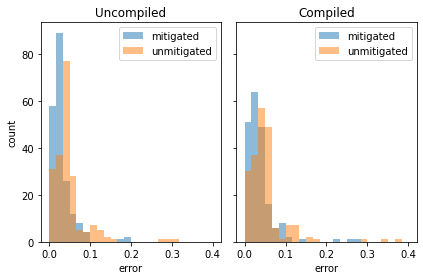

In [116]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, tight_layout=True)
bins = np.linspace(0, 0.4, 25)

axs[0].hist(uncompiled_error, bins=bins, label="mitigated", alpha=0.5)
axs[0].hist(uncompiled_unmitigated_error, bins=bins, label="unmitigated", alpha=0.5)

axs[1].hist(compiled_error, bins=bins, label="mitigated", alpha=0.5)
axs[1].hist(compiled_unmitigated_error, bins=bins, label="unmitigated", alpha=0.5)

axs[0].set_xlabel('error')
axs[1].set_xlabel('error')
axs[0].set_ylabel('count')


axs[0].set_title('Uncompiled')
axs[1].set_title('Compiled')

axs[0].legend()
axs[1].legend();

The plot above shows that error mitigation helps in both cases: with uncompiled circuits and with compiled circuits.
In fact, the mean of both histograms decreases when using error mitigation.

In [111]:
round(np.array(compiled_unmitigated_error).mean() - np.array(compiled_error).mean(), 4)

0.0137

In [112]:
round(np.array(compiled_unmitigated_error).std() - np.array(compiled_error).std(), 4)

0.0101

In this tutorial we've seen how one can use error mitigation in conjunction with circuit compilation.
For more information check out the [`bqskit`](https://bqskit.readthedocs.io/en/latest/) and [`mitiq`](https://mitiq.readthedocs.io/en/stable/) documentation.